# MTH 575 Report-4

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math as mt
import warnings
import scipy.optimize as optimize
warnings.filterwarnings("ignore")

In [ ]:
def plot_evol(U,T,X,title):
    fig = plt.figure(figsize=[10,3])
    axs = fig.subplots(nrows=1, ncols=4)
    times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
    idx = [0,1,2,3]
    for i in range(len(times)):
        ax = axs[idx[i]]
        ax.plot(X,U[times[i]])
        ax.set_title(f"t={round(T[times[i]], 2)}s")
        # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
        ax.set_ylim(-2-.1,2+.1)
        ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
        ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
        ax.grid()
    fig.suptitle(title)
    plt.show()
    plt.close('all')

In [ ]:
def fluxp(u):
    return u
fluxp = np.vectorize(fluxp)

def fluxp_d1(u):
    return 1
fluxp_d1 = np.vectorize(fluxp_d1)

def fluxm(u):
    return -u
fluxm = np.vectorize(fluxm)

def fluxm_d1(u):
    return -1
fluxm_d1 = np.vectorize(fluxm_d1)

flux = {1: fluxp, -1: fluxm}
flux_d1 = {1: fluxp_d1, -1: fluxm_d1}

def flux_split(f, f1, u):
    # The right moving and left moving flux are separated, since they require
    # different spacial dicretizations. This is implemented via the
    # Lax-Friedrich's scheme of flux-splitting. 
    m = np.max(abs(f1))
    fs = {}
    fs["+"] = (f+m*u)/2.0
    fs["-"] = (f-m*u)/2.0
    return fs

In [ ]:
def smooth_par(fs, eps=1e-6):
    # fp: current state of flux+
    # fm: current state of flux-
    # eps: numerical stability parameter

    # Here, the smoothness measurements (IS) are computed for stencils   
    # cumulatively using the 5 neighoburing points j-2 -> j+2. These are done 
    # separately for f+ and f- 

    N = fs["+"].shape[0]
    fp = fs["+"]
    fm = fs["-"]
    omega = {"+":np.zeros(shape=(N,3), dtype=np.float64), "-":np.zeros(shape=(N,3), dtype=np.float64)}

    for j in range(N):
        IS = {"+":{}, "-":{}}

        IS["+"][0] = 13/12*(fp[(j-2)%N]-2*fp[(j-1)%N]+fp[(j)%N])**2 + 1/4*(fp[(j-2)%N]-4*fp[(j-1)%N]+3*fp[(j)%N])**2
        IS["+"][1] = 13/12*(fp[(j-1)%N]-2*fp[(j)%N]+fp[(j+1)%N])**2 + 1/4*(fp[(j-1)%N]-fp[(j+1)%N])**2
        IS["+"][2] = 13/12*(fp[(j)%N]-2*fp[(j+1)%N]+fp[(j+2)%N])**2 + 1/4*(3*fp[(j)%N]-4*fp[(j+1)%N]+fp[(j+2)%N])**2

        IS["-"][0] = 13/12*(fm[(j+1)%N]-2*fm[(j+2)%N]+fm[(j+3)%N])**2 + 1/4*(3*fm[(j+1)%N]-4*fm[(j+2)%N]+fm[(j+3)%N])**2
        IS["-"][1] = 13/12*(fm[(j)%N]-2*fm[(j+1)%N]+fm[(j+2)%N])**2 + 1/4*(fm[(j)%N]-fm[(j+2)%N])**2
        IS["-"][2] = 13/12*(fm[(j-1)%N]-2*fm[(j)%N]+fm[(j+1)%N])**2 + 1/4*(fm[(j-1)%N]-4*fm[(j)%N]+3*fm[(j+1)%N])**2

        # The IS are then used to compute the un-normalized stencil weights.

        alpha = {"+":{}, "-":{}}
        for key in alpha.keys():
            alpha[key][0] = 1/10 * (1/(eps+IS[key][0]))**2
            alpha[key][1] = 6/10 * (1/(eps+IS[key][1]))**2
            alpha[key][2] = 3/10 * (1/(eps+IS[key][2]))**2

        del(IS)

        # These weights can now be normalized.
        omg = {"+":np.zeros(shape=3, dtype=np.float64), "-":np.zeros(shape=3, dtype=np.float64)}
        for key in omg.keys():
            sum = alpha[key][0]+alpha[key][1]+alpha[key][2]
            omg[key][0] = alpha[key][0]/sum
            omg[key][1] = alpha[key][1]/sum
            omg[key][2] = alpha[key][2]/sum
            del(sum)
        del(alpha)

        omega["+"][j] = omg["+"]
        omega["-"][j] = omg["-"]

    return omega

In [ ]:
def num_flux(fs, omega):
    # Once one has the weights for each stencil, one computes the weighted sum
    # of the numerical flux approximations for different stencils.
    N = fs["+"].shape[0]
    f_num = {"+":np.zeros(shape=N, dtype=np.float64), "-":np.zeros(shape=N, dtype=np.float64)}
    for j in range(N):
        fnm = {}
        fnm["+"] = omega["+"][j,0]*(2/6*fs["+"][(j-2)%N] - 7/6*fs["+"][(j-1)%N] + 11/6*fs["+"][(j)%N]) +\
                    omega["+"][j,1]*(-1/6*fs["+"][(j-1)%N] + 5/6*fs["+"][(j)%N] + 2/6*fs["+"][(j+1)%N]) +\
                    omega["+"][j,2]*(2/6*fs["+"][(j)%N] + 5/6*fs["+"][(j+1)%N] - 1/6*fs["+"][(j+2)%N])

        fnm["-"] = omega["-"][j,0]*(-1/6*fs["-"][(j-1)%N] + 5/6*fs["-"][(j)%N] + 2/6*fs["-"][(j+1)%N]) +\
                    omega["-"][j,1]*(2/6*fs["-"][(j)%N] + 5/6*fs["-"][(j+1)%N] - 1/6*fs["-"][(j+2)%N]) +\
                    omega["-"][j,2]*(11/6*fs["-"][(j+1)%N] - 7/6*fs["-"][(j+2)%N] + 2/6*fs["-"][(j+3)%N]) 

        f_num["+"][j] = fnm["+"]
        f_num["-"][j] = fnm["-"]
        del(fnm)
    return f_num

In [ ]:
def num_fluxp_der(u,T,X,del_t,del_x,eps):
    N_T = len(T)
    N_X = len(X)

    f, f1 = flux[1](u), flux_d1[1](u)
    fs = flux_split(f,f1,u)
    omega = smooth_par(fs=fs, eps=eps)
    f_num = num_flux(fs=fs, omega=omega)
    fs_d1 = np.zeros(shape=N_X, dtype=np.float64)

    for j in range(N_X):
        for key in f_num.keys():
            fs_d1[(j)%N_X] += (f_num[key][(j)%N_X] - f_num[key][(j-1)%N_X])
        fs_d1[(j)%N_X] *= 1/del_x

    return fs_d1

def num_fluxm_der(u,T,X,del_t,del_x,eps):
    N_T = len(T)
    N_X = len(X)

    f, f1 = fluxm(u), fluxm_d1(u)
    fs = flux_split(f,f1,u)
    omega = smooth_par(fs=fs, eps=eps)
    f_num = num_flux(fs=fs, omega=omega)
    fs_d1 = np.zeros(shape=N_X, dtype=np.float64)

    for j in range(N_X):
        for key in f_num.keys():
            fs_d1[(j)%N_X] += (f_num[key][(j)%N_X] - f_num[key][(j-1)%N_X])
        fs_d1[(j)%N_X] *= 1/del_x

    return fs_d1

num_flux_der = {1: num_fluxp_der, -1: num_fluxm_der}

# change the potential vector here
def get_v(u, X, l):
    v = {}
    v[-1] = 2*l*(l+1)*u[0]/X**2
    v[0] = (u[1] - u[-1])/2
    v[+1] = -2*l*(l+1)*u[0]/X**2
    return v

# change the potential vector for schw case here
def get_v_sch(u, X, l, r_s):
    v = {}
    v[-1] = (2*l*(l+1)*u[0]/X**2 + 3*r_s/X**3) * (1-r_s/X)
    v[0] = (u[1] - u[-1])/2
    v[+1] = -v[-1]
    return v

# change the source terms here
def get_source(X, t, x0):
    s = {}
    a = 1e-4

    s[-1] = -np.cos(t)*np.exp(-(X-x0)**2/a)/mt.sqrt(a*mt.pi)
    s[0] = 0
    s[+1] = np.cos(t)*np.exp(-(X-x0)**2/a)/mt.sqrt(a*mt.pi)
    return s

def rstar2r(r_star, r_s, r_min, r_max):
    # Define the function we want to find the root of.
    def f(r):
        return r_star - r - r_s*np.log(r/r_s - 1)
    # Use the brentq function from the scipy.optimize module to find the root.
    r = optimize.brentq(f, r_min, r_max)

    return r

In [ ]:
# TIME STEPPING ALGORITHMS

def butrk4_time_step(u, T, X, del_t, del_x, eps, l, t, source=False):
    # BUTCHER RK4

    u_next = {}
    f1, f2, f3, f4 = {}, {}, {}, {}
    u1, u2, u3, u4 = {}, {}, {}, {}

    v = get_v(u=u, l=l, X=X)
    if source:
        s = get_source(X=X, t=t, x0=7)
    for key in [-1,1]:
        u1[key] = u[key]
        f1[key] = -num_flux_der[key](u=u1[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f1[key] += s[key]
        u2[key] = u[key] + del_t/2 * f1[key]
    u1[0] = u[0]
    f1[0] = -v[0]
    if source:
        f1[0] += s[0]
    u2[0] = u[0] + del_t/2 * f1[0]

    v = get_v(u=u2, l=l, X=X)    
    for key in [-1,1]:
        f2[key] = -num_flux_der[key](u=u2[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f2[key] += s[key]
        u3[key] = u[key] + del_t/2 * f2[key]
    f2[0] = -v[0]
    if source:
        f2[0] += s[0]
    u3[0] = u[0] + del_t/2 * f2[0]

    v = get_v(u=u3, l=l, X=X)
    for key in [-1,1]:
        f3[key] = -num_flux_der[key](u=u3[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f3[key] += s[key]
        u4[key] = u[key] + del_t * f3[key]
    f3[0] = -v[0]
    if source:
        f3[0] += s[0]
    u4[0] = u[0] + del_t * f3[0]

    v = get_v(u=u4, l=l, X=X)
    for key in [-1,1]:
        f4[key] = -num_flux_der[key](u=u4[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f4[key] += s[key]
    f4[0] = -v[0]
    if source:
        f4[0] += s[0]    

    for key in u.keys():
        u_next[key] = u[key] + del_t/6 * (f1[key] + 2*f2[key] + 2*f3[key] + f4[key])

    return u_next[-1], u_next[0], u_next[1]

In [ ]:
# TIME STEPPING ALGORITHM FOR THE SCHWARZSCHILD CASE

def butrk4_time_step_sch(u, T, X, X_rad, del_t, del_x, eps, l, t, r_s, source=False):
    # BUTCHER RK4

    u_next = {}
    f1, f2, f3, f4 = {}, {}, {}, {}
    u1, u2, u3, u4 = {}, {}, {}, {}

    v = get_v_sch(u=u, l=l, X=X_rad, r_s=r_s)
    if source:
        s = get_source(X=X, t=t, x0=7)
    for key in [-1,1]:
        u1[key] = u[key]
        f1[key] = -num_flux_der[key](u=u1[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f1[key] += s[key]
        u2[key] = u[key] + del_t/2 * f1[key]
    u1[0] = u[0]
    f1[0] = -v[0]
    if source:
        f1[0] += s[0]
    u2[0] = u[0] + del_t/2 * f1[0]

    v = get_v_sch(u=u2, l=l, X=X_rad, r_s=r_s)   
    for key in [-1,1]:
        f2[key] = -num_flux_der[key](u=u2[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f2[key] += s[key]
        u3[key] = u[key] + del_t/2 * f2[key]
    f2[0] = -v[0]
    if source:
        f2[0] += s[0]
    u3[0] = u[0] + del_t/2 * f2[0]

    v = get_v_sch(u=u3, l=l, X=X_rad, r_s=r_s)
    for key in [-1,1]:
        f3[key] = -num_flux_der[key](u=u3[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f3[key] += s[key]
        u4[key] = u[key] + del_t * f3[key]
    f3[0] = -v[0]
    if source:
        f3[0] += s[0]
    u4[0] = u[0] + del_t * f3[0]

    v = get_v_sch(u=u4, l=l, X=X_rad, r_s=r_s)
    for key in [-1,1]:
        f4[key] = -num_flux_der[key](u=u4[key],T=T,X=X,del_t=del_t,del_x=del_x,eps=eps) - v[key]
        if source:
            f4[key] += s[key]
    f4[0] = -v[0]
    if source:
        f4[0] += s[0]    

    for key in u.keys():
        u_next[key] = u[key] + del_t/6 * (f1[key] + 2*f2[key] + 2*f3[key] + f4[key])

    return u_next[-1], u_next[0], u_next[1]

In [ ]:
def weno(U,T,X,del_t,del_x,eps,tstep="butrk4",l=0, source=False):
    # U: 3 x len(T) x len(X) field and auxillary field variables
    # V: 3 x len(T) x len(X) field and auxillary field variables
    # T: temporal grid
    # X: spacial grid
    # del_t: temporal spacing
    # del_x: spacial spacing
    # tstep: type of time stepping

    N_T = len(T)
    # N_X = len(X)

    # BUTCHER RK4
    if tstep == "butrk4":
        for n in range(N_T-1):
            u = {}
            for key in U.keys():
                u[key] = U[key][n]
            U[-1][n+1], U[0][n+1], U[1][n+1] = butrk4_time_step(u=u, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps, l=l, t=T[n], source=source)

    return U

In [ ]:
def weno_sch(U,T,X,del_t,del_x,eps,tstep="butrk4", r_s=1, l=0, source=False):
    # U: 3 x len(T) x len(X) field and auxillary field variables
    # V: 3 x len(T) x len(X) field and auxillary field variables
    # T: temporal grid
    # X: spacial grid
    # del_t: temporal spacing
    # del_x: spacial spacing
    # tstep: type of time stepping

    N_T = len(T)
    # N_X = len(X)
    X_rad = np.zeros_like(X)
    r_star_min = np.min(X)
    r_star_max = np.max(X)
    for i in range(len(X)):
        X_rad[i] = rstar2r(r_star=X[i],r_s=1,r_min=r_star_min, r_max=r_star_max)
    
    # BUTCHER RK4
    if tstep == "butrk4":
        for n in range(N_T-1):
            u = {}
            for key in U.keys():
                u[key] = U[key][n]
            U[-1][n+1], U[0][n+1], U[1][n+1] = butrk4_time_step_sch(u=u, T=T, X=X, X_rad=X_rad, del_t=del_t, del_x=del_x, eps=eps, l=l, t=T[n], r_s=r_s, source=source)

    return U

In [ ]:
del_t = 0.01
del_x = 0.05
sig = (del_x/del_t)
r_i, r_f = 1, 11
t_i, t_f = 0, 4
eps = 1e-12
l = 1

T = np.arange(t_i, t_f+eps, del_t)
X = np.arange(r_i, r_f+eps, del_x)

psi = np.zeros(shape=(len(T), len(X)))
phi = np.zeros(shape=(len(T), len(X)))
pi = np.zeros(shape=(len(T), len(X)))

# INITIAL CONDITIONS
psi[0] = np.exp(-5*(X-6)**2)
phi[0] = -10*(X-6)*np.exp(-5*(X-6)**2)

U = {}
U[-1] = phi - pi
U[0] = psi
U[+1] = phi + pi

tstep="butrk4"

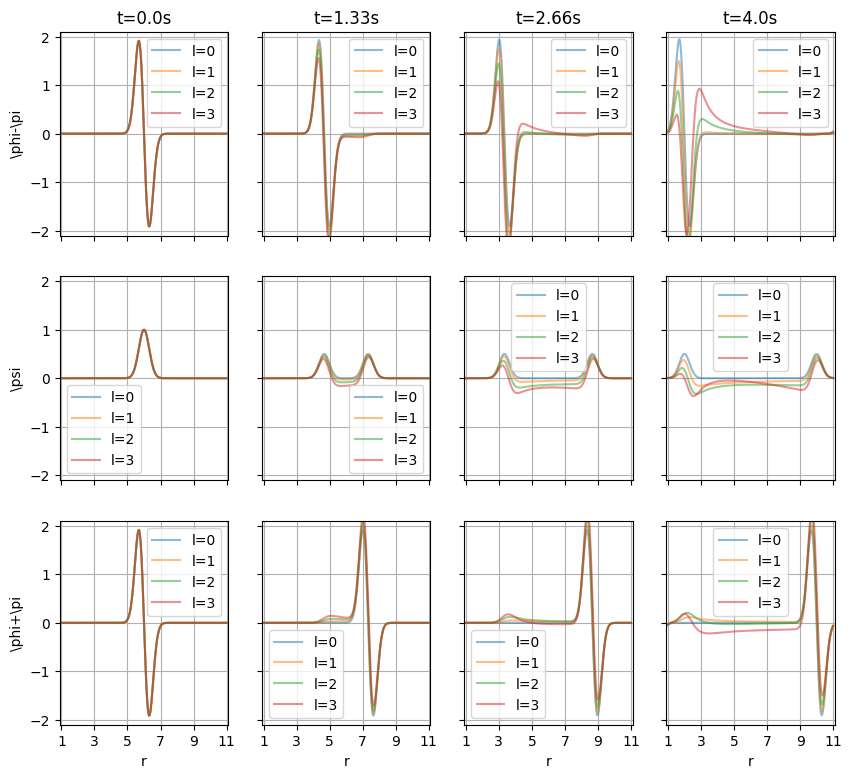

In [ ]:
fig = plt.figure(figsize=[10,9])
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]
titles=[r"\phi-\pi", r"\psi", r"\phi+\pi"]
for l in range(4):
    U = weno(U=U, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps ,tstep=tstep, l=l, source=False)
    for i in range(len(keys)):
        times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
        idx = [0,1,2,3]
        for j in range(len(times)):
            ax = axs[i, idx[j]]
            ax.plot(X,U[keys[i]][times[j]], label=f"l={l}",alpha=0.5)
            # ax.set_title(f"t={round(T[times[j]], 2)}s")
            # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
            ax.set_ylim(-2-.1,2+.1)
            ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
            ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
            ax.grid(visible=True)
            ax.legend()

for j in range(len(times)):
    axs[0,j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[-1,j].set_xlabel("r")

axs[0,0].set_ylabel(r"\phi-\pi")
axs[1,0].set_ylabel(r"\psi")
axs[2,0].set_ylabel(r"\phi+\pi")

# fig.suptitle("")
plt.show()
plt.close('all')

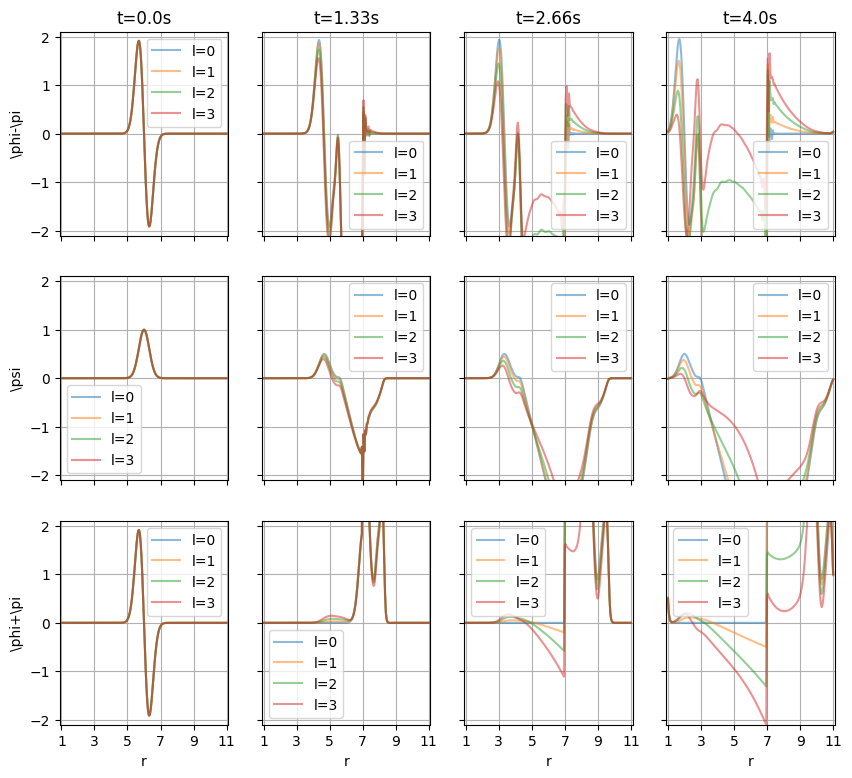

In [ ]:
fig = plt.figure(figsize=[10,9])
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]
titles=[r"\phi-\pi", r"\psi", r"\phi+\pi"]
for l in range(4):
    U = weno(U=U, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps ,tstep=tstep, l=l, source=True)
    for i in range(len(keys)):
        times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
        idx = [0,1,2,3]
        for j in range(len(times)):
            ax = axs[i, idx[j]]
            ax.plot(X,U[keys[i]][times[j]], label=f"l={l}",alpha=0.5)
            # ax.set_title(f"t={round(T[times[j]], 2)}s")
            # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
            ax.set_ylim(-2-.1,2+.1)
            ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
            ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
            ax.grid(visible=True)
            ax.legend()

for j in range(len(times)):
    axs[0,j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[-1,j].set_xlabel("r")

axs[0,0].set_ylabel(r"\phi-\pi")
axs[1,0].set_ylabel(r"\psi")
axs[2,0].set_ylabel(r"\phi+\pi")

# fig.suptitle("")
plt.show()
plt.close('all')

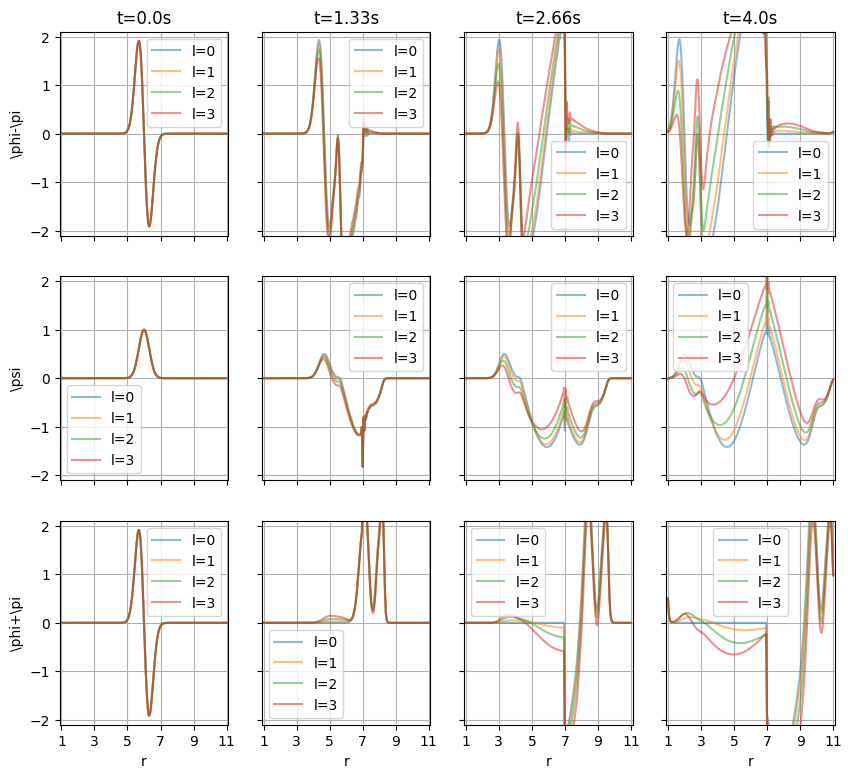

In [ ]:
fig = plt.figure(figsize=[10,9])
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]
titles=[r"\phi-\pi", r"\psi", r"\phi+\pi"]
for l in range(4):
    U = weno(U=U, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps ,tstep=tstep, l=l, source=True)
    for i in range(len(keys)):
        times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
        idx = [0,1,2,3]
        for j in range(len(times)):
            ax = axs[i, idx[j]]
            ax.plot(X,U[keys[i]][times[j]], label=f"l={l}",alpha=0.5)
            # ax.set_title(f"t={round(T[times[j]], 2)}s")
            # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
            ax.set_ylim(-2-.1,2+.1)
            ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
            ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
            ax.grid(visible=True)
            ax.legend()

for j in range(len(times)):
    axs[0,j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[-1,j].set_xlabel("r")

axs[0,0].set_ylabel(r"\phi-\pi")
axs[1,0].set_ylabel(r"\psi")
axs[2,0].set_ylabel(r"\phi+\pi")

# fig.suptitle("")
plt.show()
plt.close('all')

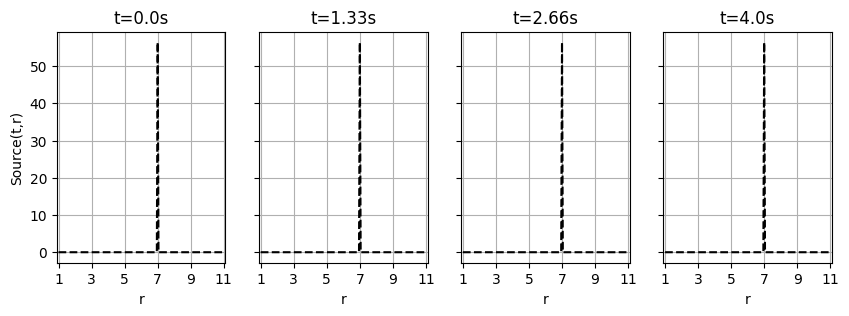

In [ ]:
fig = plt.figure(figsize=[10,3])
axs = fig.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]


times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
for j in range(len(times)):
    s = get_source(X=X, t=T[times[j]], x0=7)
    ax = axs[j]
    ax.plot(X, s[1], ls="--", color="black")
    # ax.set_ylim(-2-.1,2+.1)
    ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
    ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
    ax.grid(visible=True)

for j in range(len(times)):
    axs[j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[j].set_xlabel("r")

axs[0].set_ylabel("Source(t,r)")
plt.show()
plt.close('all')

In [ ]:
del_t = 0.01
del_x = 0.05
sig = (del_x/del_t)
r_i, r_f = 1, 11
t_i, t_f = 0, 2
eps = 1e-12

T = np.arange(t_i, t_f+eps, del_t)
X = np.arange(r_i, r_f+eps, del_x)

psi = np.zeros(shape=(len(T), len(X)))
phi = np.zeros(shape=(len(T), len(X)))
pi = np.zeros(shape=(len(T), len(X)))

# INITIAL CONDITIONS
psi[0] = np.exp(-5*(X-6)**2)
phi[0] = -10*(X-6)*np.exp(-5*(X-6)**2)

U = {}
U[-1] = phi - pi
U[0] = psi
U[+1] = phi + pi

tstep="butrk4"

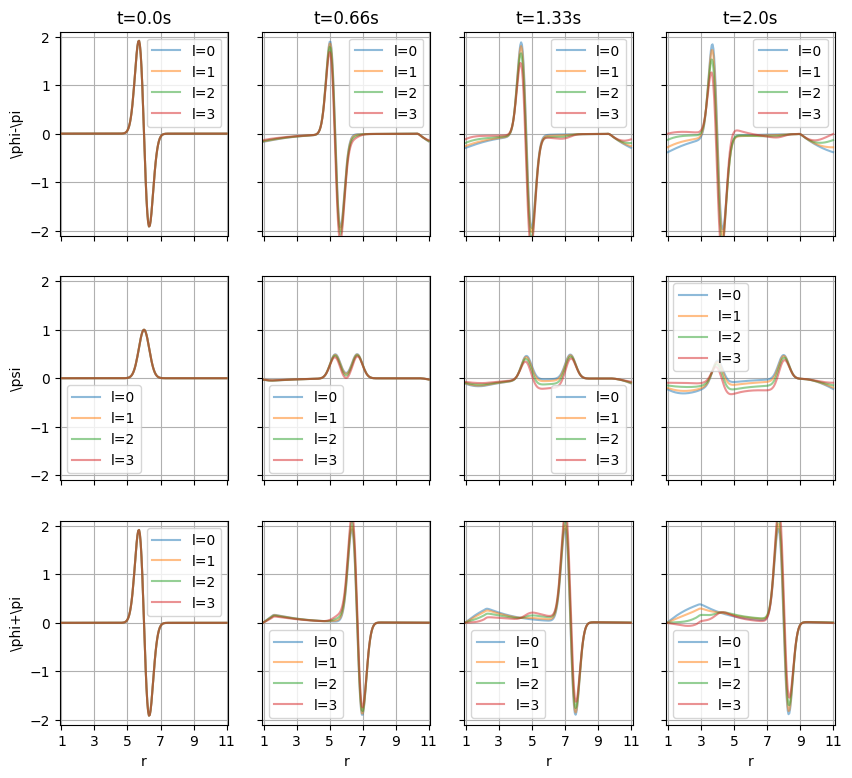

In [ ]:
r_s = 1
fig = plt.figure(figsize=[10,9])
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]
titles=[r"\phi-\pi", r"\psi", r"\phi+\pi"]
for l in range(4):
    U = weno_sch(U=U, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps ,tstep=tstep, l=l, r_s=r_s, source=False)
    for i in range(len(keys)):
        times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
        idx = [0,1,2,3]
        for j in range(len(times)):
            ax = axs[i, idx[j]]
            ax.plot(X,U[keys[i]][times[j]], label=f"l={l}",alpha=0.5)
            # ax.set_title(f"t={round(T[times[j]], 2)}s")
            # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
            ax.set_ylim(-2-.1,2+.1)
            ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
            ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
            ax.grid(visible=True)
            ax.legend()

for j in range(len(times)):
    axs[0,j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[-1,j].set_xlabel("r")

axs[0,0].set_ylabel(r"\phi-\pi")
axs[1,0].set_ylabel(r"\psi")
axs[2,0].set_ylabel(r"\phi+\pi")

# fig.suptitle("")
plt.show()
plt.close('all')

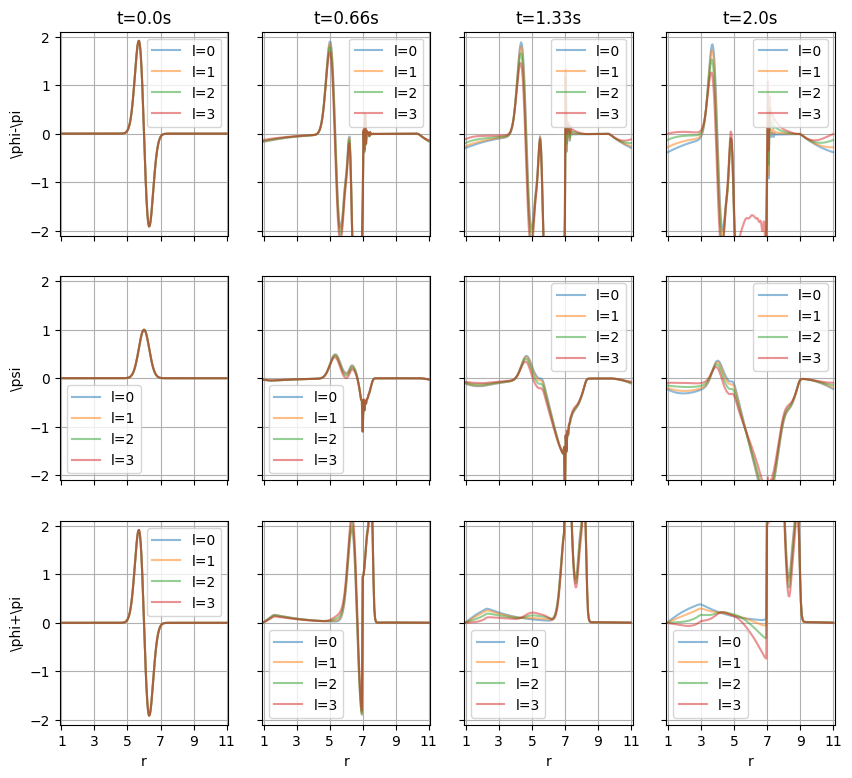

In [ ]:
r_s = 1
fig = plt.figure(figsize=[10,9])
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]
titles=[r"\phi-\pi", r"\psi", r"\phi+\pi"]
for l in range(4):
    U = weno_sch(U=U, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps ,tstep=tstep, l=l, r_s=r_s, source=True)
    for i in range(len(keys)):
        times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
        idx = [0,1,2,3]
        for j in range(len(times)):
            ax = axs[i, idx[j]]
            ax.plot(X,U[keys[i]][times[j]], label=f"l={l}",alpha=0.5)
            # ax.set_title(f"t={round(T[times[j]], 2)}s")
            # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
            ax.set_ylim(-2-.1,2+.1)
            ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
            ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
            ax.grid(visible=True)
            ax.legend()

for j in range(len(times)):
    axs[0,j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[-1,j].set_xlabel("r")

axs[0,0].set_ylabel(r"\phi-\pi")
axs[1,0].set_ylabel(r"\psi")
axs[2,0].set_ylabel(r"\phi+\pi")

# fig.suptitle("")
plt.show()
plt.close('all')

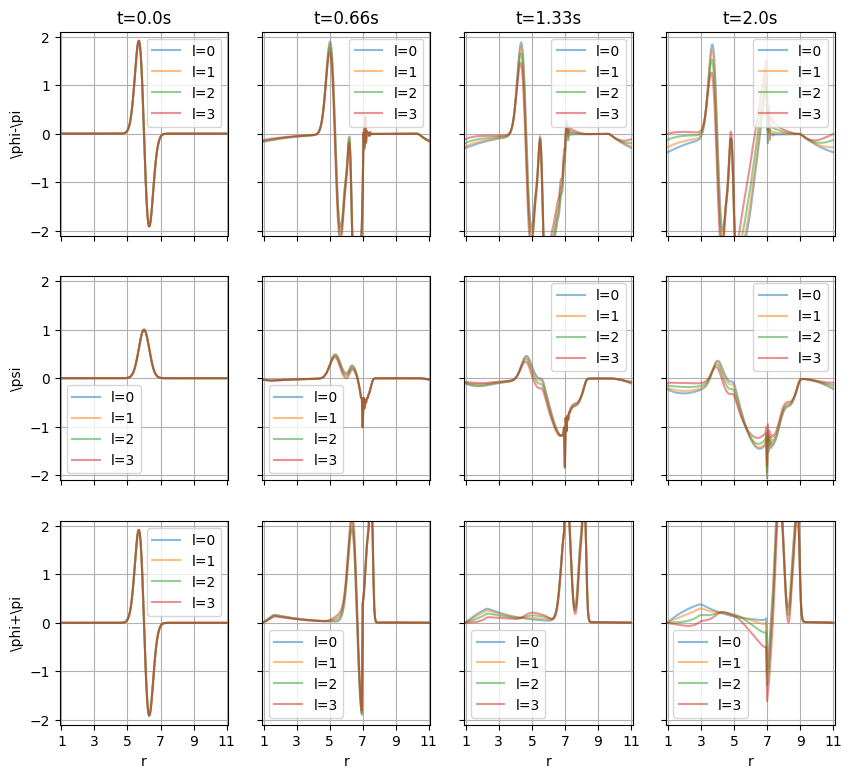

In [ ]:
r_s = 1
fig = plt.figure(figsize=[10,9])
axs = fig.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
keys = [-1,0,1]
titles=[r"\phi-\pi", r"\psi", r"\phi+\pi"]
for l in range(4):
    U = weno_sch(U=U, T=T, X=X, del_t=del_t, del_x=del_x, eps=eps ,tstep=tstep, l=l, r_s=r_s, source=True)
    for i in range(len(keys)):
        times = np.linspace(0,len(T)-1,4, dtype=np.uint16)
        idx = [0,1,2,3]
        for j in range(len(times)):
            ax = axs[i, idx[j]]
            ax.plot(X,U[keys[i]][times[j]], label=f"l={l}",alpha=0.5)
            # ax.set_title(f"t={round(T[times[j]], 2)}s")
            # ax.set_ylim(np.min(U[times[i]])-.1,np.max(U[times[i]])+.1)
            ax.set_ylim(-2-.1,2+.1)
            ax.set_xlim(np.min(X)-.1,np.max(X)+.1)
            ax.set_xticks(np.arange(np.min(X), np.max(X)+0.001, 2))
            ax.grid(visible=True)
            ax.legend()

for j in range(len(times)):
    axs[0,j].set_title(f"t={round(T[times[j]], 2)}s")
    axs[-1,j].set_xlabel("r")

axs[0,0].set_ylabel(r"\phi-\pi")
axs[1,0].set_ylabel(r"\psi")
axs[2,0].set_ylabel(r"\phi+\pi")

# fig.suptitle("")
plt.show()
plt.close('all')